# TP - Statistique


Dans un premier temps, nous allons ajoutez nos bibliothèques ainsi que importer notre bases de données.
Notre base de donnée 'UserdCarData' proviens de https://www.kaggle.com/datasets/shubham1kumar/usedcar-data?select=UserCarData.csv .
Nous entrons la partie de code qui permet de séparer les données automatiquement selon le format ".csv" afin de pouvoir traiter les données.

In [3]:
"""
27/05/2024
BELLONCLE Robin - BOTHUA Pierre

                                        Projet Base de Données
                                        Mathématiques statistique
                                        
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Charger le fichier CSV
file_path = 'UserCarData.csv'
Data = pd.read_csv(file_path, sep=',')
Data.columns = [col.strip() for col in Data.columns]  # Supprimer les espaces autour des noms de colonnes



Ensuite nous allons afficher la répartitions des données entre le prix de ventes et le kilométage des véhicules.
Le but de cette manipulation est de voir si des avleurs sont totalement incohérentes auquel cas nous pourrons les traiter indépendament

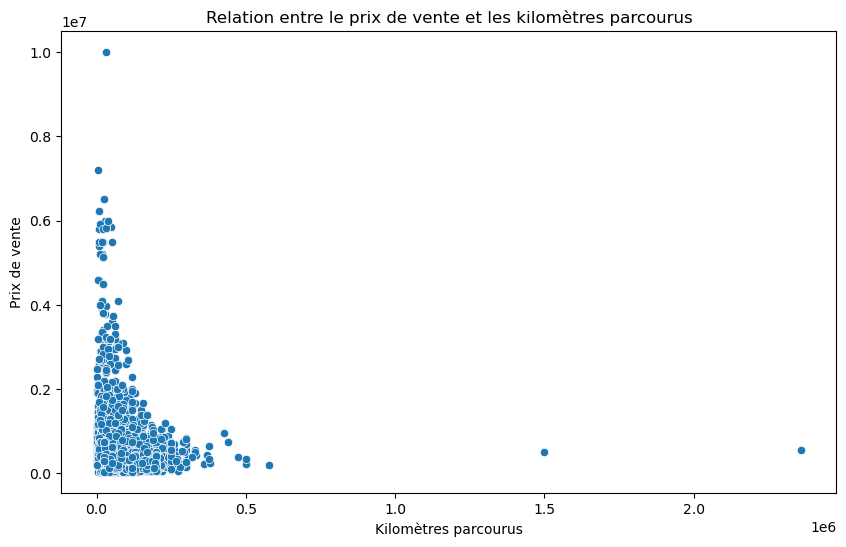

In [4]:
# Sélection des colonnes pour l'analyse
columns = ["year", "selling_price", "km_driven", "mileage", "engine", "max_power", "seats"]
year_data, selling_price_data, km_driven_data, mileage_data, engine_data, max_power_data, seats_data = [Data[col] for col in columns]

# Relation entre le prix de vente et les kilomètres parcourus
plt.figure(figsize=(10, 6))
sns.scatterplot(x=km_driven_data, y=selling_price_data)
plt.xlabel('Kilomètres parcourus')
plt.ylabel('Prix de vente')
plt.title('Relation entre le prix de vente et les kilomètres parcourus')
plt.show()

Nous réalisons la matrice de corélation afin de visuelaliser quel valeur sont le plus en liens avec lesquels afin de determiner les facteurs.

               selling_price  km_driven      year   mileage  max_power
selling_price       1.000000  -0.222158  0.412302 -0.126280   0.749674
km_driven          -0.222158   1.000000 -0.428548 -0.172980  -0.038159
year                0.412302  -0.428548  1.000000  0.328544   0.226598
mileage            -0.126280  -0.172980  0.328544  1.000000  -0.374621
max_power           0.749674  -0.038159  0.226598 -0.374621   1.000000


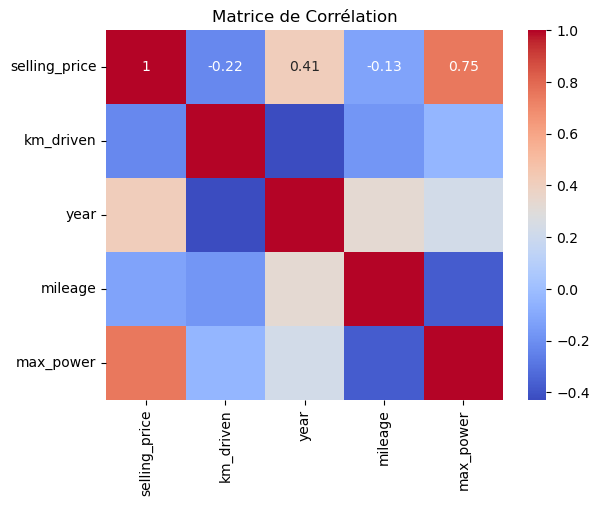

In [10]:
# Matrice de corrélation
correlation_matrix = Data[['selling_price', 'km_driven', 'year', 'mileage', 'max_power']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

Pour répondre à la question de recherche qui est :
Comment estimer le prix d'un véhicule sur le marché en fonction de sa puissance, son année de fabrication ainsi que son kilométrage.

Pour réaliser cela nous réalisons une régression linéaire multiple.

In [11]:
# Regression linéaire multiple
# Ajout d’une constante pour l’intercept
X = sm.add_constant(Data[['year', 'km_driven', 'max_power']])
# Ajustement du modèle
model = sm.OLS(Data['selling_price'], X).fit()
# Affichage du résumé du modèle
print(model.summary())

# Sélection Pas-à-Pas avec colonnes limitées
def forward_selection_limited(data, response):
    predictors = ['year', 'km_driven', 'max_power']
    remaining = set(predictors)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            score = sm.OLS.from_formula(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.OLS.from_formula(formula, data).fit()
    return model

# Application de la sélection pas-à-pas aux données
limited_model = forward_selection_limited(Data, 'selling_price')
print(limited_model.summary())



                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4545.
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:44:45   Log-Likelihood:            -1.1485e+05
No. Observations:                7906   AIC:                         2.297e+05
Df Residuals:                    7902   BIC:                         2.297e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.915e+07   3.29e+06    -27.111      0.0

Le bout de code suivant permet de prédire le prix du véhicule dont nous rentrerons manuelement les caractéristiques. Cette estimation se basera sur la régression linéaire faite précédemment.

In [12]:
# Prediction function using the model
def predict_selling_price(model, year, km_driven, max_power):
    # Extract coefficients from the model
    intercept = model.params['Intercept']
    beta_year = model.params['year']
    beta_km_driven = model.params['km_driven']
    beta_max_power = model.params['max_power']

    # Calculate the predicted selling price
    predicted_price = (
        intercept +
        (beta_year * year) +
        (beta_km_driven * km_driven) +
        (beta_max_power * max_power)
    )
    return predicted_price

# Given values for a car: year=2018, km_driven=60000, max_power=165
year = 2018
km_driven = 60000
max_power = 165

# Predict the selling price
predicted_price = predict_selling_price(limited_model, year, km_driven, max_power)
print(f"Predicted selling price for a car from {year} with {max_power} hp and {km_driven} km driven: {predicted_price:.2f}")

Predicted selling price for a car from 2018 with 165 hp and 60000 km driven: 2007006.10


À présent, nous souhaitons observer les choix stratégiques des 6 marques les plus présentes dans la base de données, c'est à dire si une marque à plus tendance à produire des voitures peu chères, peu puissantes, plus chères ... ainsi de suite.

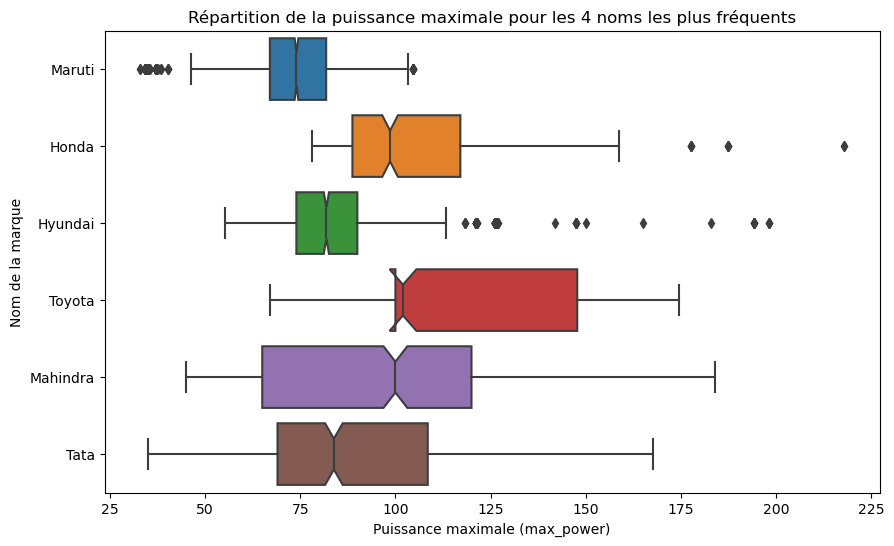

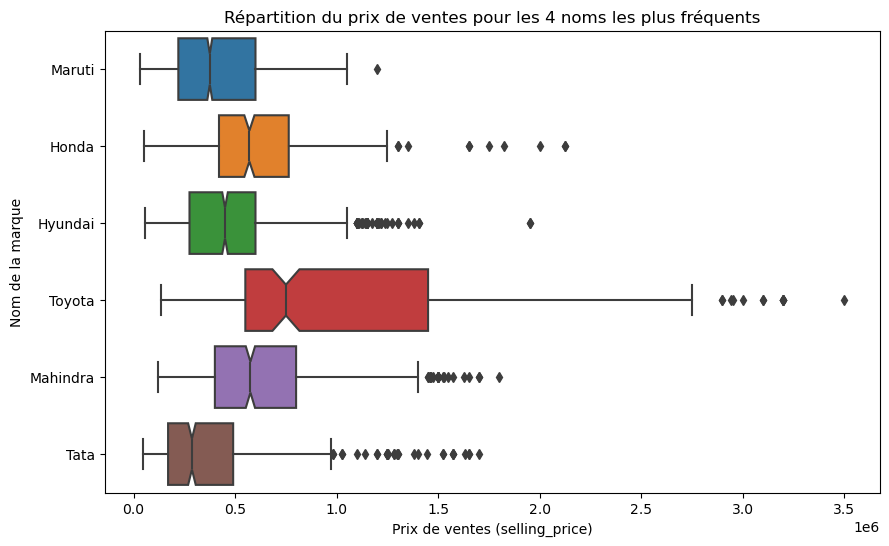

In [13]:
# Boxplot de la puissance maximale pour les 6 noms les plus fréquents
top_4_names = Data['name'].value_counts().nlargest(6).index
filtered_data = Data[Data['name'].isin(top_4_names)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='max_power', y='name', notch=True)
plt.title("Répartition de la puissance maximale pour les 4 noms les plus fréquents")
plt.xlabel("Puissance maximale (max_power)")
plt.ylabel("Nom de la marque")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='selling_price', y='name', notch=True)
plt.title("Répartition du prix de ventes pour les 4 noms les plus fréquents")
plt.xlabel("Prix de ventes (selling_price)")
plt.ylabel("Nom de la marque")
plt.show()

Ci-dessous, nous réaliserons 2 analyses ANOVA : l'une qui présente le prix en fonction de l'année et l'autre qui présente le prix du véhicule en fonction de sa puissance et de son année.

                sum_sq      df          F        PR(>F)
C(year)   6.587877e+05    26.0  21.141997  7.600333e-96
Residual  9.442723e+06  7879.0        NaN           NaN


C:\Users\rfhba\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


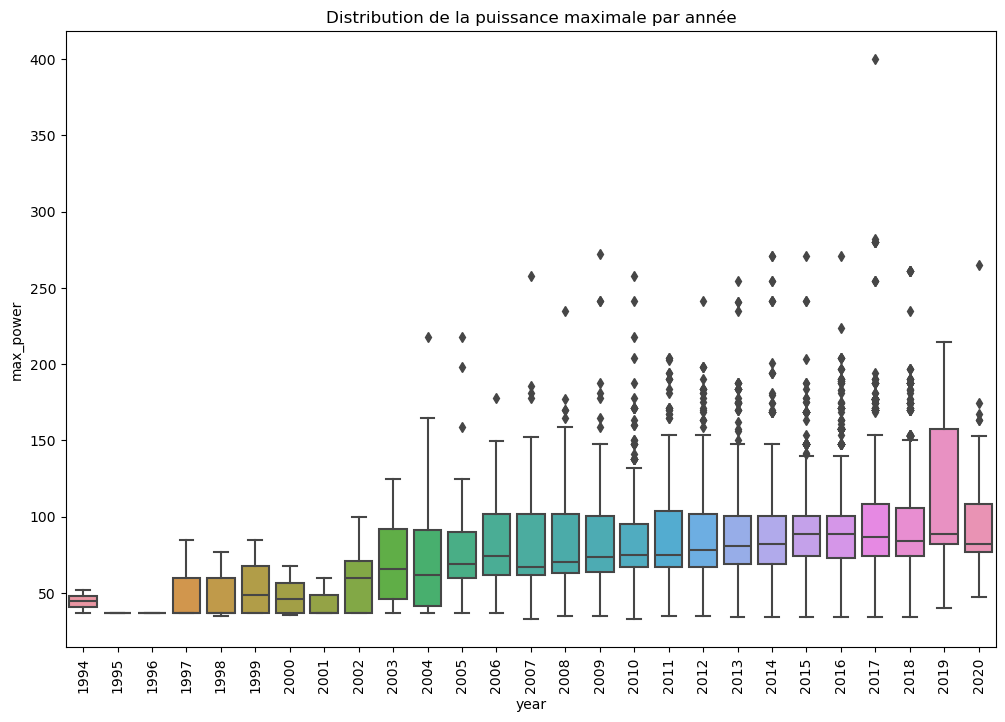

                 sum_sq      df             F  PR(>F)
C(year)    5.951803e+14    26.0    106.296127     0.0
max_power  2.234960e+15     1.0  10377.958213     0.0
Residual   1.696578e+15  7878.0           NaN     NaN


C:\Users\rfhba\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


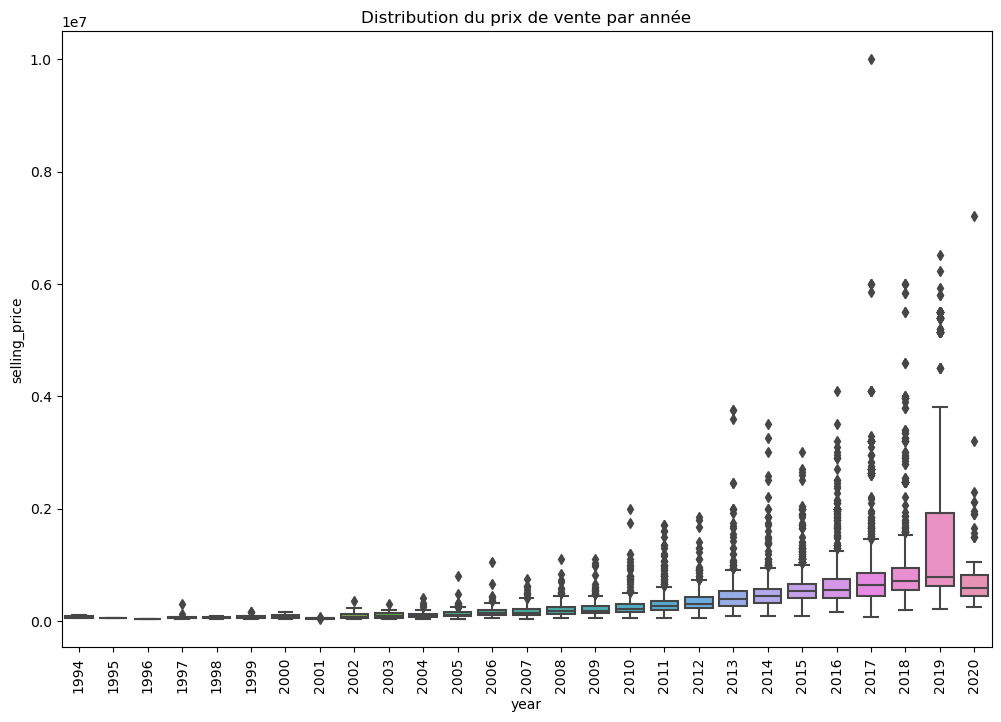

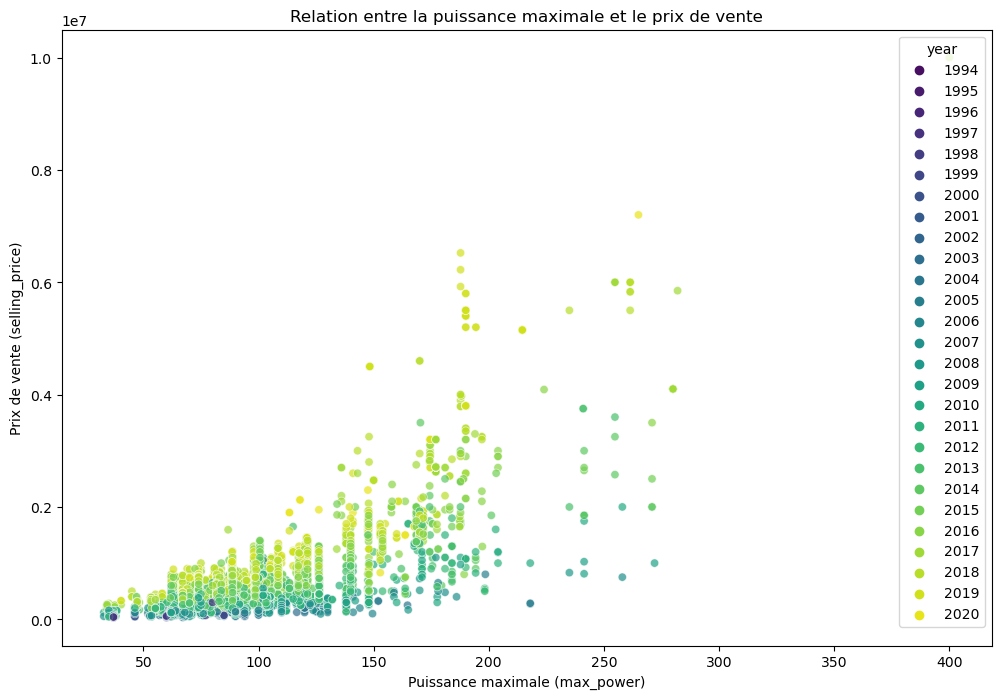

In [14]:
    ###############################################
    #################### ANOVA ####################
    ###### Puissance max, kilométrage, année ######
    
from statsmodels.formula.api import ols

###### Prix en fonction de l'année #######

# Convert 'year' to categorical variable
Data['year'] = Data['year'].astype('category')

# Convertir 'year' en variable catégorielle
Data['year'] = Data['year'].astype('category')

# Définir le modèle ANOVA avec 'max_power' comme variable dépendante et 'year' comme facteur
model = ols('max_power ~ C(year)', data=Data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Afficher les résultats de l'ANOVA
print(anova_table)

# Optionnel: sauvegarder les résultats dans un fichier CSV
anova_table.to_csv('anova_results.csv')

# Visualiser la distribution de max_power par année
plt.figure(figsize=(12, 8))
sns.boxplot(x='year', y='max_power', data=Data)
plt.xticks(rotation=90)
plt.title('Distribution de la puissance maximale par année')
plt.show()



###### Prix en fonction de l'année et de la puissance du moteur #######

# Définir le modèle ANOVA avec 'selling_price' comme variable dépendante, et 'year' et 'max_power' comme facteurs
model_price = ols('selling_price ~ C(year) + max_power', data=Data).fit()
anova_table_price = sm.stats.anova_lm(model_price, typ=2)

# Afficher les résultats de l'ANOVA
print(anova_table_price)

# Optionnel: sauvegarder les résultats dans un fichier CSV
anova_table_price.to_csv('anova_results_selling_price.csv')

# Visualiser la distribution de selling_price par année
plt.figure(figsize=(12, 8))
sns.boxplot(x='year', y='selling_price', data=Data)
plt.xticks(rotation=90)
plt.title('Distribution du prix de vente par année')
plt.show()

# Visualiser la relation entre max_power et selling_price
plt.figure(figsize=(12, 8))
sns.scatterplot(x='max_power', y='selling_price', data=Data, hue='year', palette='viridis', alpha=0.7)
plt.title('Relation entre la puissance maximale et le prix de vente')
plt.xlabel('Puissance maximale (max_power)')
plt.ylabel('Prix de vente (selling_price)')
plt.show()